
## TW9 Unsupervised Learning

### Clustering

Basic use of common clustering models

- K-means

- DBSCAN



### Set up

In [65]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [66]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

    
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

## K-means model

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
    
The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. 

See the details of these hyperparameters: 

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### 1. A synthetic dataset

This example creates a synthetic dataset with make_blobs, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

#### Generate a dataset

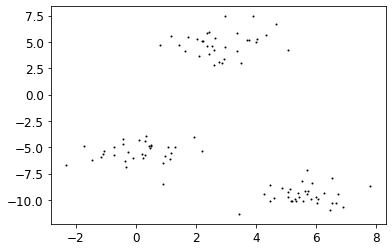

In [67]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 10)

plot_data(X)




#### K-means model 

In [68]:
from sklearn.cluster import KMeans

# create a K-means model
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=10, algorithm='full')


In [69]:
# fit the model
kmeans.fit(X)

KMeans(algorithm='full', init='random', max_iter=10, n_clusters=3, n_init=1)

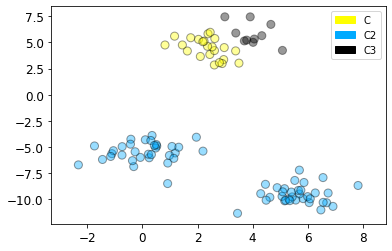

In [70]:
# plot the resulting clusters

plot_labelled_scatter(X, kmeans.labels_, ['C', 'C2', 'C3'])

### 2. Real dataset: Fruit dataset

#### Load the data

A data file: ./data/fruit_data_with_colors.txt

In [71]:
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')


fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [72]:
# Since this dataset already include class labels, we can evaluate the model based on that
# Have X and y

X = fruits[['mass', 'width', 'height', 'color_score']].values
y = fruits[['fruit_label']]-1

print(X)
print(y)

[[192.     8.4    7.3    0.55]
 [180.     8.     6.8    0.59]
 [176.     7.4    7.2    0.6 ]
 [ 86.     6.2    4.7    0.8 ]
 [ 84.     6.     4.6    0.79]
 [ 80.     5.8    4.3    0.77]
 [ 80.     5.9    4.3    0.81]
 [ 76.     5.8    4.     0.81]
 [178.     7.1    7.8    0.92]
 [172.     7.4    7.     0.89]
 [166.     6.9    7.3    0.93]
 [172.     7.1    7.6    0.92]
 [154.     7.     7.1    0.88]
 [164.     7.3    7.7    0.7 ]
 [152.     7.6    7.3    0.69]
 [156.     7.7    7.1    0.69]
 [156.     7.6    7.5    0.67]
 [168.     7.5    7.6    0.73]
 [162.     7.5    7.1    0.83]
 [162.     7.4    7.2    0.85]
 [160.     7.5    7.5    0.86]
 [156.     7.4    7.4    0.84]
 [140.     7.3    7.1    0.87]
 [170.     7.6    7.9    0.88]
 [342.     9.     9.4    0.75]
 [356.     9.2    9.2    0.75]
 [362.     9.6    9.2    0.74]
 [204.     7.5    9.2    0.77]
 [140.     6.7    7.1    0.72]
 [160.     7.     7.4    0.81]
 [158.     7.1    7.5    0.79]
 [210.     7.8    8.     0.82]
 [164.  

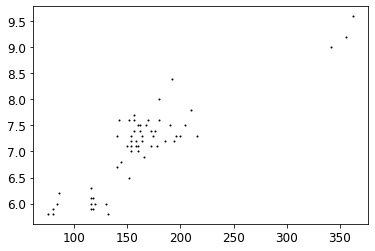

In [73]:
# plot the data (only use 2 attributes, 'mass', 'width')

plot_data(X)

#### Standarizing the data (scaling)

- Note that in general, it's important to scale the individual features before applying k-means clustering.

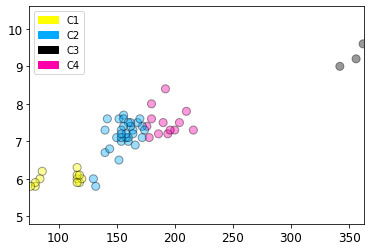

In [74]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X)

# plot the cluster
plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

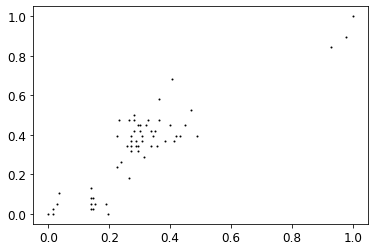

In [75]:
from sklearn.preprocessing import MinMaxScaler

# normalized the data

X_normalized = MinMaxScaler().fit(X).transform(X)

# plot the data

plot_data(X_normalized)

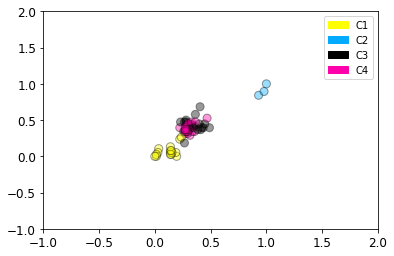

In [76]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X_normalized)

# plot the cluster
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

#### K-means model

- This example showing k-means used to find 4 clusters in the fruits dataset.

## k-means vs. DBSCAN clustering

### 1. A simple dataset

#### Generate a dataset

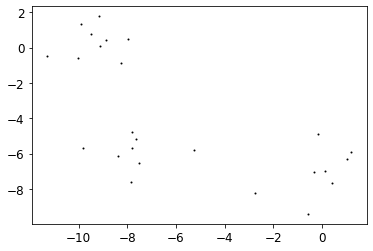

In [77]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 9, n_samples = 25)

plot_data(X)

#### K-means model

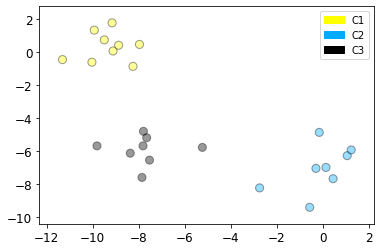

In [78]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])






#### DBSCAN model

Read the description of the model parameters

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

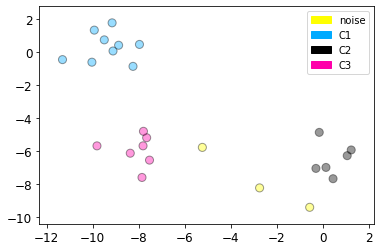

In [79]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2', 'C3'])





## TW9 Tasks

### Part 1 

### (1) Apply the following clustering models on a more complex dataset below. 

- K-means

- DBSCAN

### A more complicated dataset

#### Generate a synthetic dataset

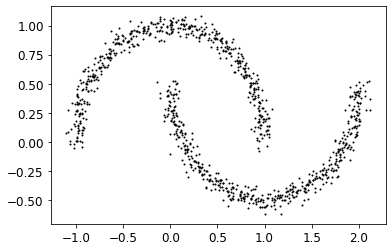

In [80]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plot_data(X)

#### K-means model


- Apply k-means model

- use k = 2

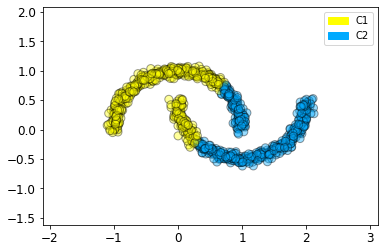

In [81]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2'])




#### DBSCAN model

- Apply DBSCAN model

- use eps=0.2, min_samples=5

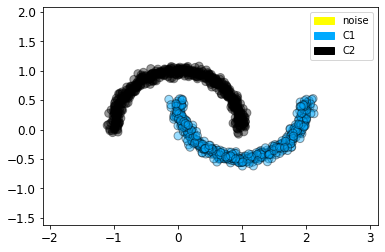

In [82]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2'])




### (2) Apply k-means model on breast cancer dataset and check the model performance

- check also notebook, clustering_Kmeans.ipynb for implementation details of k-means model

#### load the data

- load breat cancer dataset from sklearn.datasets (set the parameter, return_X_y = True)

- print the first five X values

- print the first five y values

In [91]:
#Load Breast Cancer dataset
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X, y = load_breast_cancer(return_X_y=True)

#dataFrame
import numpy as np
import pandas as pd

cancer_X = pd.DataFrame(X)
cancer_X.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [92]:
cancer_y = pd.DataFrame(y)
cancer_y.head()

,0
0,0
1,0
2,0
3,0
4,0


#### scaling the data

- scale X values using MinMaxScaler()

- print the normalized (scaled) values of the first five X

In [85]:
from sklearn.preprocessing import MinMaxScaler

# normalized the data

X_normalized = MinMaxScaler().fit(cancer_X).transform(cancer_X)


cancer_normalized_X = pd.DataFrame(X_normalized)
cancer_normalized_X.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


#### K-means model

- Apply k-means model with k = 2

In [93]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_normalized)

KMeans(n_clusters=2)

### (3) Evaluate Model performance: K-means vs. DBSCAN

##### evaluation method 1:

- print the sum of all correctly predicted data (y_predicted==y_cancer)

- Since we have y_cancer values, we compare the predicted value to its y_cancer value. The ratio of correctly predicted class can represent the accuracy of the model. 


##### evaluaton method 2:

- calculate Silhouette scores (examples are given in cluster_eval.ipynb)

In [94]:
# Method 1:
kmeans_k_4 = KMeans(n_clusters=4, random_state=42).fit(X_normalized)


In [103]:
countTrue = 0
y_pred = kmeans_k_4.labels_
for i in range(0, len(y_pred)):
    if  y_pred[i]==y[i]:
        countTrue = countTrue + 1
correctRate = countTrue/len(y)
print(correctRate)

0.6502636203866432


In [104]:
# Method 2:
from sklearn import metrics
from sklearn.metrics import silhouette_score

score = silhouette_score(X_normalized, kmeans_k_4.labels_)
print(score)


0.3195294099620425


## Part 2

### Optimal parameters of clustering models

Please check the examples of k-means and DBSCAN models in the following notebook (available on TW9 page) and find out optimal parameters of each of the algorithms for the given dataset. 

- clustering_Kmeans.ipynb

- clustering_DBSCAN.ipynb


### Clustering by K-means

In [105]:
from sklearn.metrics import silhouette_score

In [106]:
silhouette_score(X_normalized, kmeans.labels_)

0.3845494883485513

In [108]:
kmeans_per_k = []

for k in range(1,10):
    kmeans_per_k.append(KMeans(n_clusters=k, random_state=42).fit(X_normalized))
inertias = [model.inertia_ for model in kmeans_per_k]

In [115]:
inertias

[354.43661334440105,
 215.83831972044837,
 187.03838972753252,
 170.29262861835062,
 156.9326563113454,
 146.97084480465196,
 138.57443285243292,
 131.1808359451817,
 126.71242458805297]

In [112]:
silhouette_scores = []
for model in kmeans_per_k[1:]:
    silhouette_scores.append(silhouette_score(X_normalized, model.labels_))

silhouette_scores

[0.3845494883485513,
 0.3322499754550183,
 0.3195294099620425,
 0.16717796807210156,
 0.14367339937624063,
 0.14713996017964037,
 0.15164110703820666,
 0.1472170976123957]

### Clustering by DBSCAN

In [117]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X_normalized)
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
cu = dbscan2.fit(X_normalized)
dbscan3 = DBSCAN(eps=0.5, min_samples=5)
dbscan3.fit(X_normalized)
dbscan4 = DBSCAN(eps=1, min_samples=5)
dbscan4.fit(X_normalized)

DBSCAN(eps=1)

In [118]:
silhouettes = []
epsList = [0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4]
for r in epsList:
    db = DBSCAN(eps=r, min_samples=10).fit(X_normalized)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    score = silhouette_score(X_normalized, labels)
    silhouettes.append(score)

In [119]:
silhouettes

[0.10623950343275461,
 0.3617984597332187,
 0.4507866338676547,
 0.5142349250185276,
 0.5312751817820737,
 0.5790209289824328,
 0.5734373609005109]

### Submissions:

- upload the notebook (clustering_basic.ipynb) on GitHub

- Write the link to the notebook on Canvas